<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/negative_samples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to use negative examples

In some scenarios it might be useful to explicitly show the model images that should be considered background, these are called "negative examples" and are images that do not contain any annotations.

In this tutorial we're going to be training two raccoons detectors and observe how they perform on images of dogs and cats. One of the models will be trained only with images of raccoons, while the other will also have access to images of dogs and cats (the negative examples).

As you might already have imagined, the model that was trained with raccoon images predicts all animals to be raccoons!

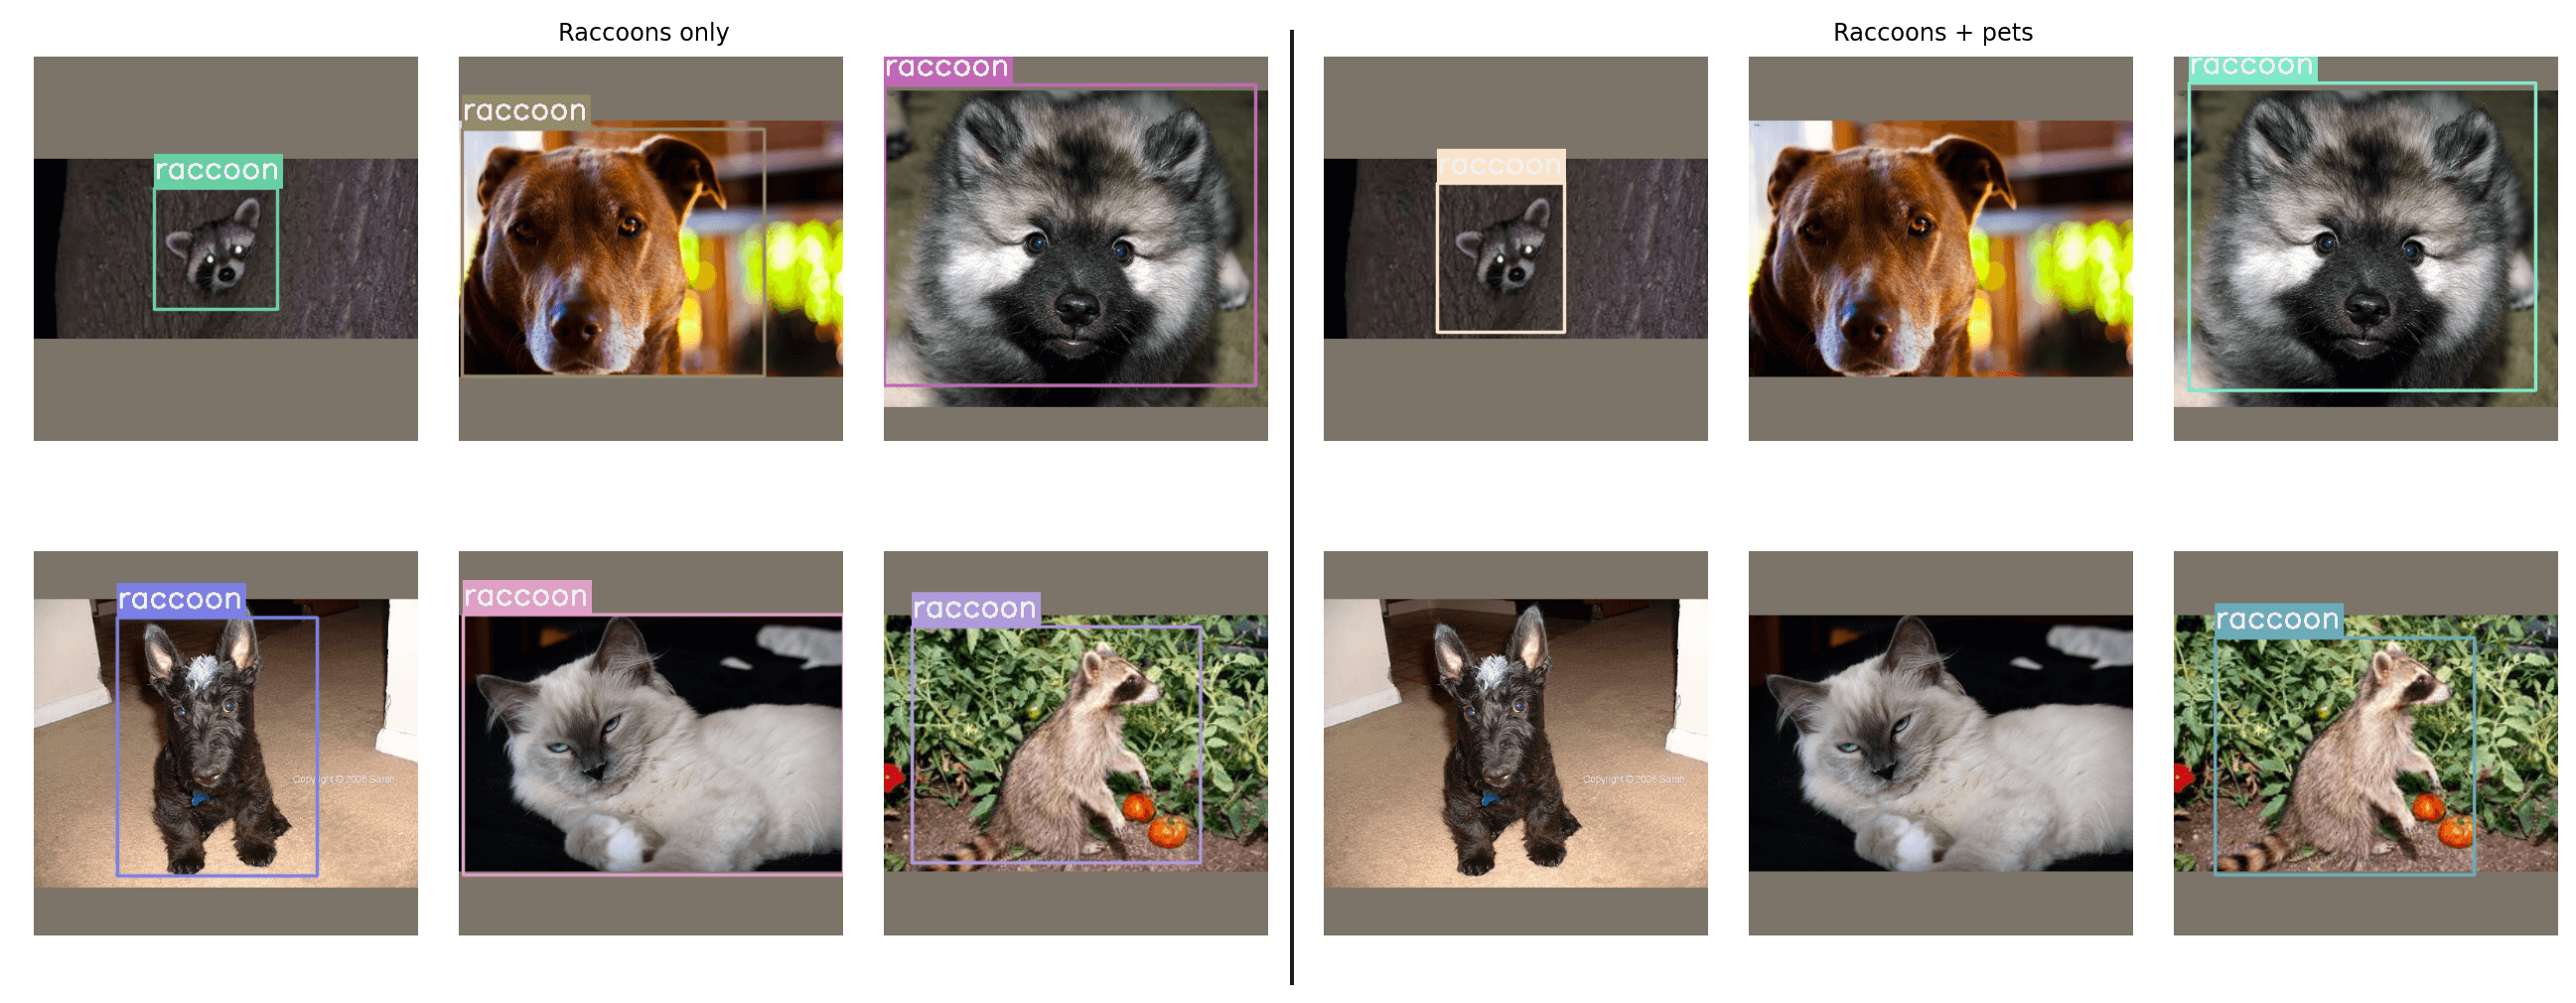

!!! info "Info"
    The first half of this tutorial is almost an exact copy from [this](https://airctic.com/dataset_voc_nb/) tutorial.

## Installation

In [1]:
!pip install icevision[all] icedata

## Imports

In [2]:
from icevision.all import *

### Define class_map

Even when training with pets data the only class we want to detect is **raccoon**.

In [3]:
class_map = ClassMap(['raccoon'])

## Raccoon dataset

The dataset is stored on github, so a simple `git clone` will do.

In [4]:
!git clone https://github.com/datitran/raccoon_dataset

The raccoon dataset uses the VOC annotation format, icevision natively supports this format:

In [5]:
raccoon_data_dir = Path('raccoon_dataset')
raccoon_parser = parsers.voc(annotations_dir=raccoon_data_dir /'annotations',
                            images_dir=raccoon_data_dir /'images',
                            class_map=class_map)

Let's go ahead and parse our data with the default 80% train, 20% valid, split.

In [27]:
raccoon_train_records, raccoon_valid_records = raccoon_parser.parse()

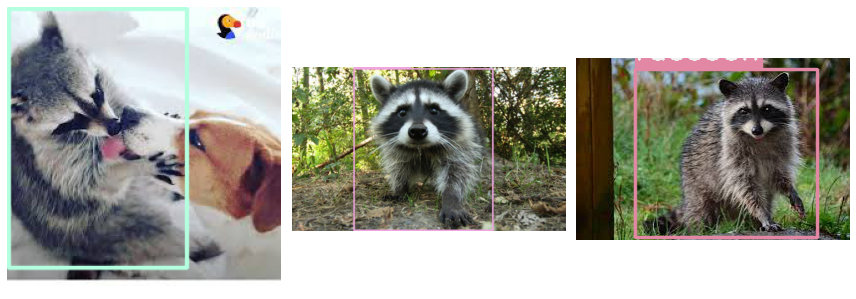

In [25]:
show_records(random.choices(raccoon_train_records, k=3), ncols=3, class_map=class_map)

## Pets dataset

With icedata we can easily download the pets dataset:

In [8]:
pets_data_dir = icedata.pets.load_data()

Here we have a twist, instead of using the standard parser (`icedata.pets.parser`) which would parse all annotations, we will instead create a custom parser that returns an **empty list** for `labels` and `bboxes`. 

Remember the steps for generating a custom parser (check [this](https://airctic.com/custom_parser/) tutorial for more information), first define all your mixins and call `generate_template`:

In [9]:
class PetsImageParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    pass

In [10]:
PetsImageParser.generate_template()

def __iter__(self) -> Any:
def imageid(self, o) -> Hashable:
def image_width_height(self, o) -> Tuple[int, int]:
    return get_image_size(self.filepath(o))
def filepath(self, o) -> Union[str, Path]:
def bboxes(self, o) -> List[BBox]:
def labels(self, o) -> List[int]:


And now we use that to fill the required methods:

In [11]:
class PetsImageParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    def __init__(self, data_dir):
        self.image_filepaths = get_image_files(data_dir)

    def __iter__(self) -> Any:
        yield from self.image_filepaths

    def imageid(self, o) -> Hashable:
        return o.stem

    def filepath(self, o) -> Union[str, Path]:
        return o

    def image_width_height(self, o) -> Tuple[int, int]:
        return get_image_size(self.filepath(o))

    def labels(self, o) -> List[int]:
        return []

    def bboxes(self, o) -> List[BBox]:
        return []

Now we're ready to instantiate the parser and parse the data:

In [28]:
pets_parser = PetsImageParser(pets_data_dir)
pets_train_records, pets_valid_records = pets_parser.parse()

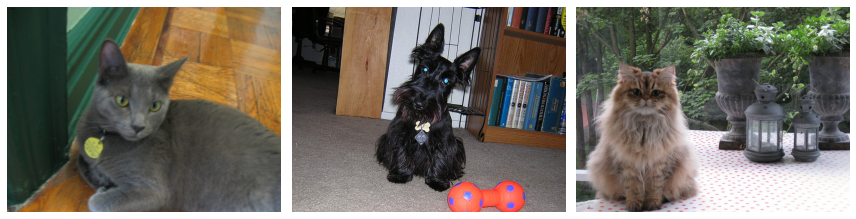

In [13]:
show_records(random.choices(pets_train_records, k=3), ncols=3, class_map=class_map)

## Transforms

Let's define a simple list of transforms, they are the same for both datasets.

In [14]:
presize = 512
size = 384

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size), tfms.A.Normalize()])

## Datasets and DataLoaders

We create the raccoon dataset and dataloader as normal:

In [15]:
raccoon_train_ds = Dataset(raccoon_train_records, train_tfms)
raccoon_valid_ds = Dataset(raccoon_valid_records, valid_tfms)

raccoon_train_dl = efficientdet.train_dl(raccoon_train_ds, batch_size=16, num_workers=4, shuffle=True)
raccoon_valid_dl = efficientdet.valid_dl(raccoon_valid_ds, batch_size=16, num_workers=4, shuffle=False)

For adding the pets data, we simply have to combine the list of records. Note that the pets dataset contains a lot more images than the raccoon dataset, so we'll get only 100 images for train and 30 for valid, feel free to change these numbers and explore the results!

In [16]:
combined_train_ds = Dataset(raccoon_train_records + pets_train_records[:100], train_tfms)
combined_valid_ds = Dataset(raccoon_valid_records + pets_valid_records[:30], valid_tfms)

combined_train_dl = efficientdet.train_dl(combined_train_ds, batch_size=16, num_workers=4, shuffle=True)
combined_valid_dl = efficientdet.valid_dl(combined_valid_ds, batch_size=16, num_workers=4, shuffle=False)

Let's take a look at the combined dataset:

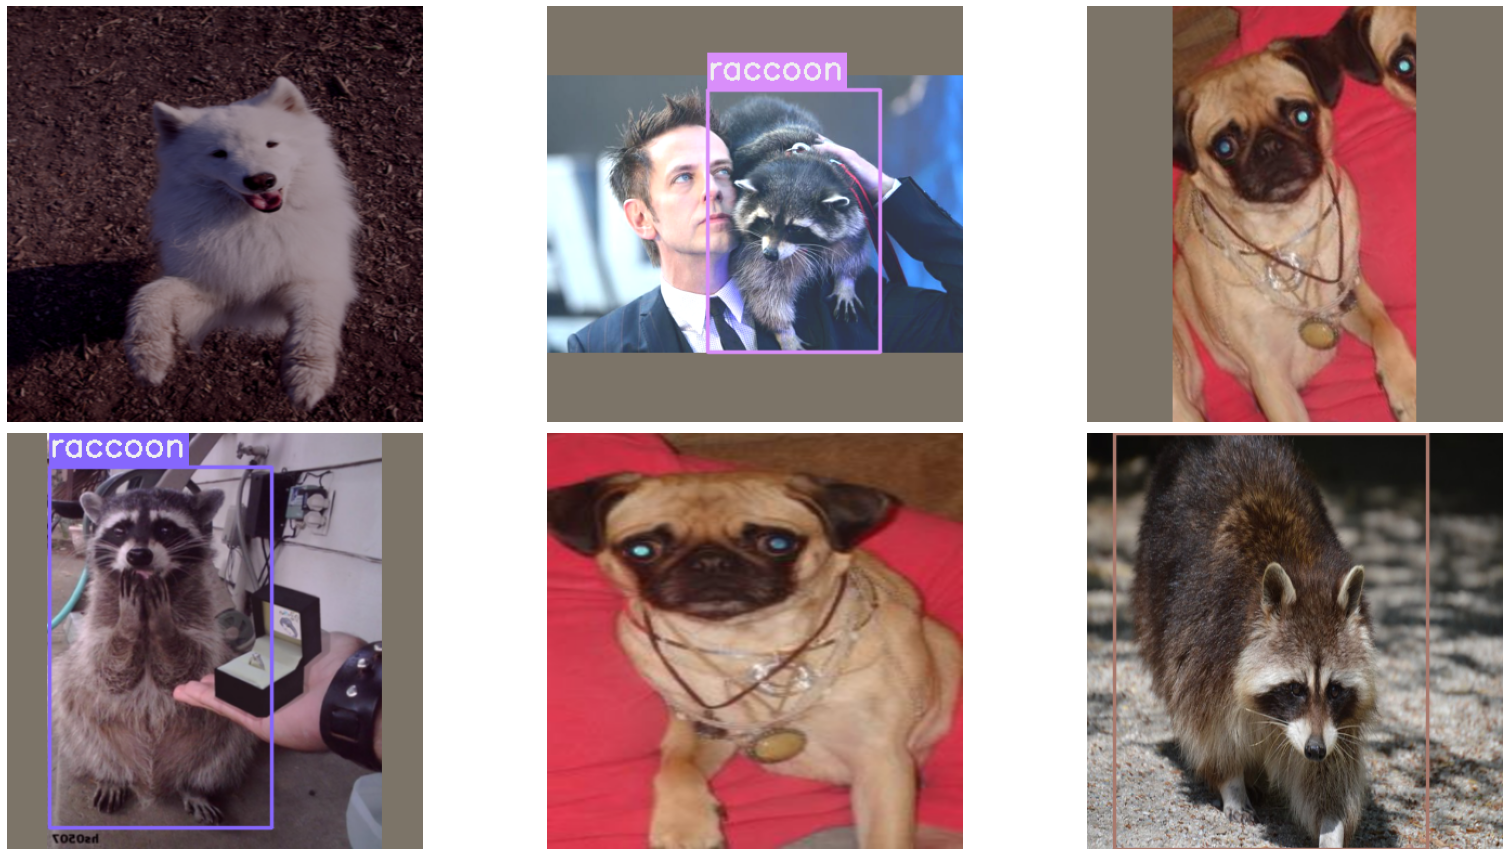

In [17]:
show_samples(random.choices(combined_train_ds, k=6), class_map=class_map, ncols=3)

## Metrics

As usual, let's stick with our `COCOMetric`:

In [18]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

## Models

We're now ready to train a separate model for each dataset and see how the results change!

### Raccoons only

In [19]:
raccoon_model = efficientdet.model('tf_efficientdet_lite0', num_classes=len(class_map), img_size=size)
raccoon_learn = efficientdet.fastai.learner(dls=[raccoon_train_dl, raccoon_valid_dl], model=raccoon_model, metrics=metrics)

In [20]:
raccoon_learn.fine_tune(30, 1e-2, freeze_epochs=5)

If only raccoon photos are showed during training, everything is a raccoon!

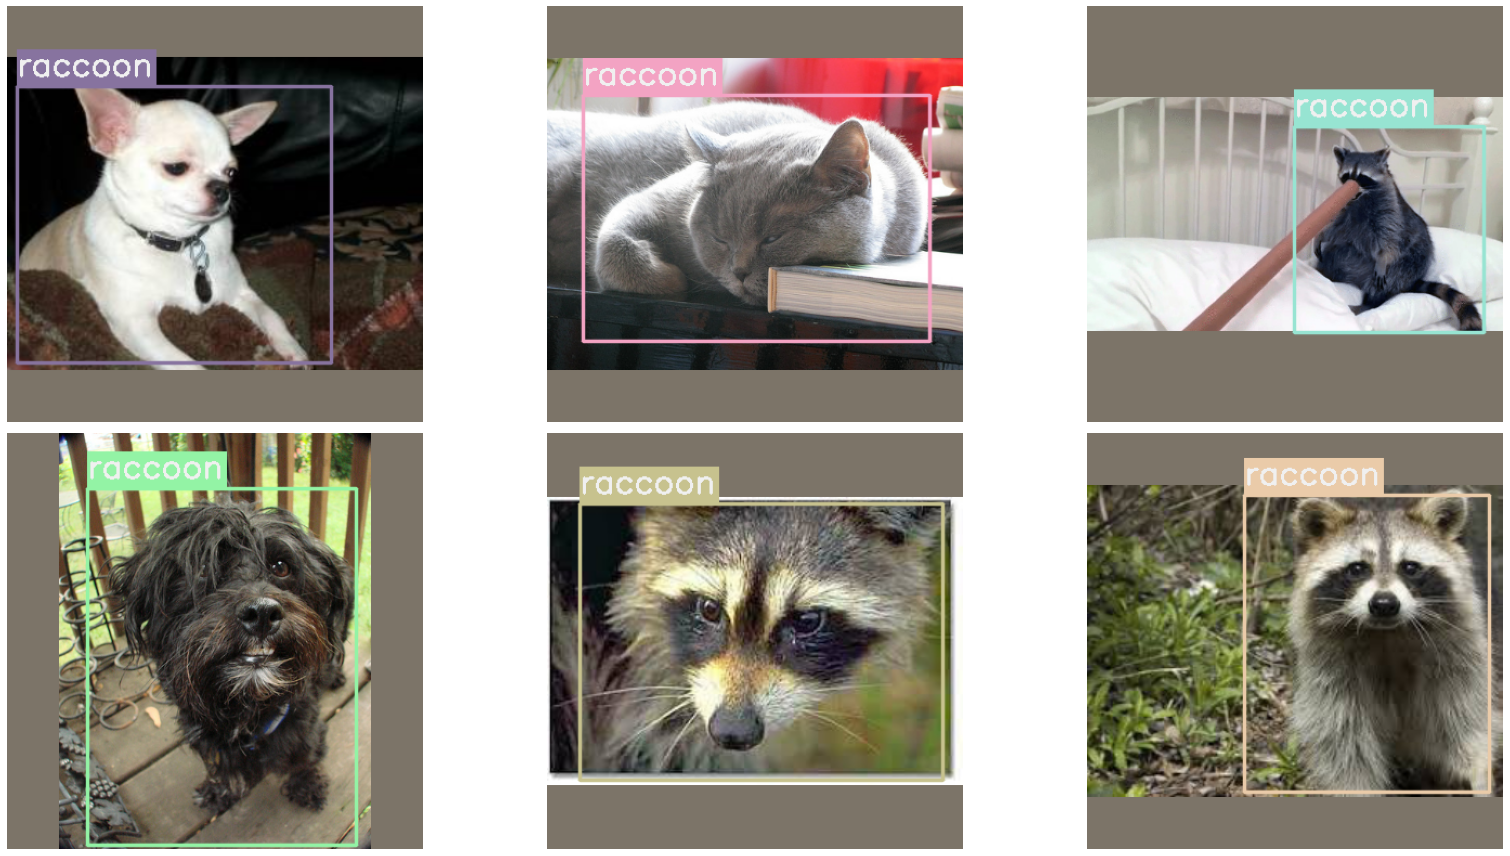

In [21]:
efficientdet.show_results(raccoon_model, combined_valid_ds, class_map=class_map)

### Raccoons + pets

In [22]:
combined_model = efficientdet.model('tf_efficientdet_lite0', num_classes=len(class_map), img_size=size)
combined_learn = efficientdet.fastai.learner(dls=[combined_train_dl, combined_valid_dl], model=combined_model, metrics=metrics)

In [23]:
combined_learn.fine_tune(30, 1e-2, freeze_epochs=5)

When negative samples are used during training, the model get's way better understading what **is not** a raccoon.

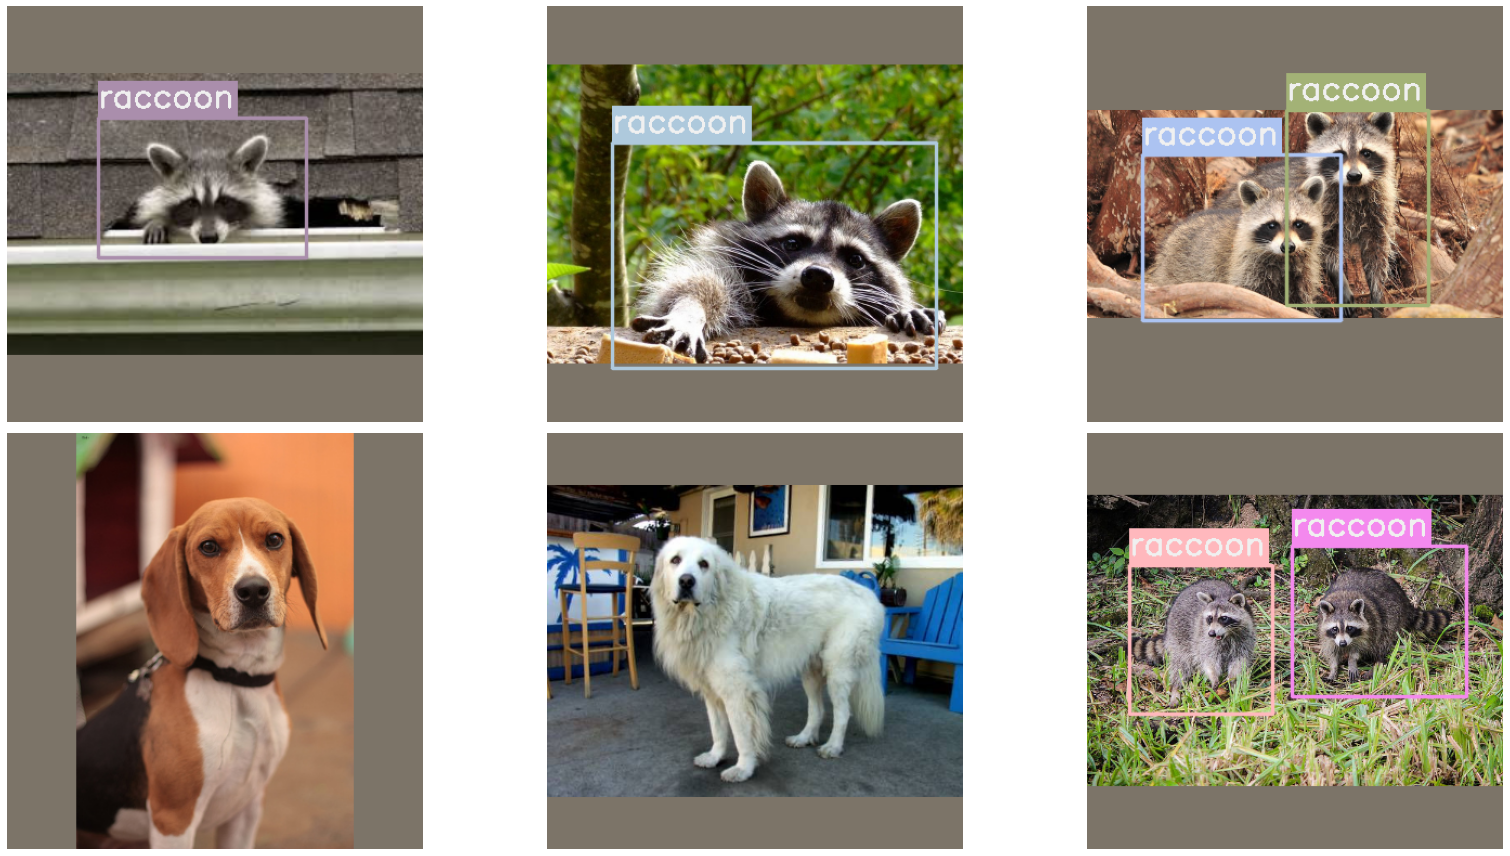

In [26]:
efficientdet.show_results(combined_model, combined_valid_ds, class_map=class_map)

## Happy Learning!

That's it folks! If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).